In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats

import seaborn as sns
import plotly.express as px
import plotly.io as pio

from scipy.stats import normaltest
import statsmodels.api as sm
from sklearn import preprocessing
import os
from datetime import datetime
from dateutil.relativedelta import relativedelta

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)
# seaborn.set(rc={'figure.figsize': (30, 10)})
plt.ion()

# SQLite database setup

In [2]:
import import_ipynb
import setup_sqlite
# %run setup_sqlite.ipynb

importing Jupyter notebook from setup_sqlite.ipynb


In [3]:
# setup_sqlite.drop_tables()
# setup_sqlite.create_tables()

# Data Acquisition
Some of the data was retrieved manually from the Transitapp website.

Some of the data was retrieved from https://transitapp.com/rats.csv at 6:00PM EST via a cronjob. This may mean that the dataset name might be mismatched from what the website actually gives you (typically off by one day).

However all of the datasets are non-overlapping.

## Reformatting raw data files from cloud server storage

In [4]:
root_data_dir = "rat_data"

data_files = os.listdir(root_data_dir)
formatted_files = []

# Remove helper sh files
for file in data_files:
    if file.endswith(".sh"):
        data_files.remove(file)

# Standardize name of files and remove conflicting ones
for i, file in enumerate(data_files):
    if file.startswith("rats"):
        date = file.split(" ")[1].split(".")[0]
        dt_end = datetime.strptime(date, "%Y-%m-%d")
        dt_start = dt_end - relativedelta(days=30)

        new_name = f"Transit app rat reports - {dt_start.strftime('%Y-%m-%d')} to {dt_end.strftime('%Y-%m-%d')}.csv"
        old_path = os.path.join("rat_data", file)
        new_path = os.path.join("rat_data", new_name)

        if new_name in data_files:
            print(f"CONFLICT -- {file}, {data_files[data_files.index(new_name)]}")
        else:
            print(f"{old_path} --> {new_path}")
            os.rename(old_path, new_path)
            formatted_files.append(new_name)
    else:
        formatted_files.append(file)

formatted_files = sorted(formatted_files)

CONFLICT -- rats 2023-11-11.csv, Transit app rat reports - 2023-10-12 to 2023-11-11.csv
CONFLICT -- rats 2023-11-12.csv, Transit app rat reports - 2023-10-13 to 2023-11-12.csv
CONFLICT -- rats 2023-11-13.csv, Transit app rat reports - 2023-10-14 to 2023-11-13.csv
CONFLICT -- rats 2023-11-14.csv, Transit app rat reports - 2023-10-15 to 2023-11-14.csv
CONFLICT -- rats 2023-11-15.csv, Transit app rat reports - 2023-10-16 to 2023-11-15.csv
CONFLICT -- rats 2023-11-19.csv, Transit app rat reports - 2023-10-20 to 2023-11-19.csv
CONFLICT -- rats 2023-11-20.csv, Transit app rat reports - 2023-10-21 to 2023-11-20.csv
CONFLICT -- rats 2023-11-21.csv, Transit app rat reports - 2023-10-22 to 2023-11-21.csv
CONFLICT -- rats 2023-11-22.csv, Transit app rat reports - 2023-10-23 to 2023-11-22.csv
CONFLICT -- rats 2023-11-23.csv, Transit app rat reports - 2023-10-24 to 2023-11-23.csv
CONFLICT -- rats 2023-11-24.csv, Transit app rat reports - 2023-10-25 to 2023-11-24.csv


## Collation of datasets and adding some addition columns of information

In [5]:
for file in formatted_files:
    if file.endswith(".csv"):
        full_path = os.path.join(root_data_dir, file)
        tokens = full_path.split(" ")

        date_start = tokens[-3]
        date_end = tokens[-1].split(".")[0]
        
        rat_sv = pd.read_csv(full_path)
        rat_sv = rat_sv.drop(["lines_served"], axis=1)

        stations_rows = []
        sightings_rows = []
        
        for index, row in rat_sv.iterrows():
            stations_rows.append([
                row["station_id"],
                row["station_name"]
            ])
            sightings_rows.append([
                row["station_id"],
                row["so_many"], 
                row["one_or_two"], 
                row["none"], 
                date_start, 
                date_end
            ])
        
        setup_sqlite.insert_stations(stations_rows)
        setup_sqlite.insert_sightings(sightings_rows)

In [6]:
# rat_sv["total_voters"] = rat_sv[["so_many", "one_or_two", "none"]].sum(axis=1)
# rat_sv = rat_sv.sort_values("total_voters", ascending=False)

# rat_sv["% so_many"] = rat_sv["so_many"] / rat_sv["total_voters"]
# rat_sv["% one_or_two"] = rat_sv["one_or_two"] / rat_sv["total_voters"]
# rat_sv["% none"] = rat_sv["none"] / rat_sv["total_voters"]
# rat_sv["seen_rats"] = (3 * rat_sv["so_many"]) + (1.5 * rat_sv["one_or_two"])
# rat_sv["% rats"] = (rat_sv["so_many"] + rat_sv["one_or_two"]) / rat_sv["total_voters"]

# rat_sv.head(20)

sightings_df = pd.read_sql("SELECT * from sightings", setup_sqlite.get_connector())
stations_df = pd.read_sql("SELECT * from stations", setup_sqlite.get_connector())

sightings_df["date_start"] = pd.to_datetime(sightings_df["date_start"])
sightings_df["date_end"] = pd.to_datetime(sightings_df["date_end"])

In [7]:
print(stations_df.shape)
print(sightings_df.shape)
print(sightings_df.head(10))
print(sightings_df.info())

(413, 2)
(15401, 6)
   station_id  so_many  one_or_two  none date_start   date_end
0       17496        2           7     1 2023-10-02 2023-11-01
1       17700        4           9     3 2023-10-02 2023-11-01
2       17546       37          38    30 2023-10-02 2023-11-01
3       20017        5           5     4 2023-10-02 2023-11-01
4       20055       17          10    11 2023-10-02 2023-11-01
5       17921        8           9     7 2023-10-02 2023-11-01
6       17792        6          23    12 2023-10-02 2023-11-01
7       17872        7           5     5 2023-10-02 2023-11-01
8       17497        9          22    13 2023-10-02 2023-11-01
9       17725        8          16    12 2023-10-02 2023-11-01
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15401 entries, 0 to 15400
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   station_id  15401 non-null  int64         
 1   so_many     15401 non-null  in

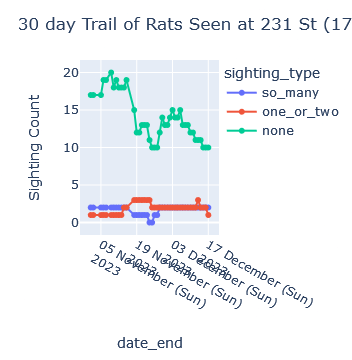

<html>
<head><meta charset="utf-8" /></head>
<body>
    <div>                            <div id="aa71c03a-6a97-40db-a7f6-88559f53a980" class="plotly-graph-div" style="height:100%; width:100%;"></div>            <script type="text/javascript">                                    window.PLOTLYENV=window.PLOTLYENV || {};                                    if (document.getElementById("aa71c03a-6a97-40db-a7f6-88559f53a980")) {                    Plotly.newPlot(                        "aa71c03a-6a97-40db-a7f6-88559f53a980",                        [{"hovertemplate":"sighting_type=so_many\u003cbr\u003edate_end=%{x}\u003cbr\u003evalue=%{y}\u003cextra\u003e\u003c\u002fextra\u003e","legendgroup":"so_many","line":{"color":"#636efa","dash":"solid"},"marker":{"symbol":"circle"},"mode":"markers+lines","name":"so_many","orientation":"v","showlegend":true,"x":["2023-11-01T00:00:00","2023-11-02T00:00:00","2023-11-05T00:00:00","2023-11-06T00:00:00","2023-11-07T00:00:00","2023-11-09T00:00:00","2023-11-10T

In [11]:
def plot_station_trend(station_name, station_id=None):
    if not station_id:
        station_id = stations_df[stations_df["station_name"] == station_name]["station_id"].values
        if len(station_id) > 1:
            print("Station name conflict, this station requires a specific ID due to duplicate names")
            return

    station_data = sightings_df[sightings_df["station_id"] == station_id[0]]
    melted_data = station_data.melt(["station_id", "date_start","date_end"], var_name="sighting_type", value_vars=["so_many", "one_or_two", "none"]) 

    fig = px.line(melted_data, x="date_end", y="value", color="sighting_type", markers=True)
    fig.update_layout(
        title=f"30 day Trail of Rats Seen at {station_name} ({station_id[0]})",
        xaxis_tickformat='%d %B (%a)<br>%Y',
        yaxis_title="Sighting Count"
    )
    fig.show()

    print(pio.to_html(fig, include_plotlyjs=False))
    

plot_station_trend("231 St")

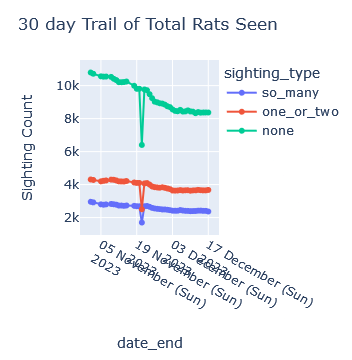

In [9]:
def plot_summary():
    nyc_total_sightings = sightings_df.groupby(["date_start", "date_end"]).sum(["so_many","one_or_two","none"]).drop(columns="station_id").reset_index()
    melted_data = nyc_total_sightings.melt(["date_start","date_end"], var_name="sighting_type", value_vars=["so_many", "one_or_two", "none"]) 

    fig = px.line(melted_data, x="date_end", y="value", color="sighting_type", markers=True)
    fig.update_layout(
        title=f"30 day Trail of Total Rats Seen",
        xaxis_tickformat='%d %B (%a)<br>%Y',
        yaxis_title="Sighting Count"
    )
    fig.show()

plot_summary()